<a href="https://colab.research.google.com/github/psgrigoletti/margem-liquida-colab/blob/main/Sobre_a_inflacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importa as bibliotecas necessárias


*   https://pypi.org/project/sidrapy/





In [1]:
!pip install sidrapy
!pip install -U kaleido
!pip install -q condacolab # necessário para salvar como imagem
!pip install plotly # Importa a biblioteca plotly

import sidrapy
from datetime import datetime
import requests
from time import sleep
from requests import ConnectTimeout, ReadTimeout
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from IPython.display import Image
import condacolab # necessário para salvar como imagem

condacolab.install()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!


# Importa as variações do IPCA

In [2]:
# Importa as variações do IPCA
# Tabela 1737: https://sidra.ibge.gov.br/tabela/1737
#	Unidade Territorial - 1	Brasil
# Variáveis: 63	IPCA - Variação mensal, 69	IPCA - Variação acumulada no ano, 2263	IPCA - Variação acumulada em 3 meses, 
#            2264	IPCA - Variação acumulada em 6 meses, 2265	IPCA - Variação acumulada em 12 meses
# Últimos 240 meses

ipca_raw = sidrapy.get_table(table_code = '1737',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,69,2263,2264,2265',
                             period = 'last 240',
                             verify_ssl=False)

In [3]:
ipca_raw.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Mês (Código),Mês,Variável (Código),Variável
1,1,Brasil,2,%,3.02,1,Brasil,200211,novembro 2002,63,IPCA - Variação mensal
2,1,Brasil,2,%,10.22,1,Brasil,200211,novembro 2002,69,IPCA - Variação acumulada no ano
3,1,Brasil,2,%,5.12,1,Brasil,200211,novembro 2002,2263,IPCA - Variação acumulada em 3 meses
4,1,Brasil,2,%,7.51,1,Brasil,200211,novembro 2002,2264,IPCA - Variação acumulada em 6 meses


In [4]:
ipca =  (
  ipca_raw
  .loc[1:,['V', 'D2C', 'D3N']]
  .rename(columns = {'V': 'value', 'D2C': 'date', 'D3N': 'variable'})
  .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                      'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                      'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                      'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                      'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
          date  = lambda x: pd.to_datetime(x['date'], format = "%Y%m"),
          value = lambda x: x['value'].astype(float)
   )
  .pipe(lambda x: x.loc[x.date > '2007-01-01'])
)
ipca

,value,date,variable
256,0.44,2007-02-01,Var. mensal (%)
257,0.88,2007-02-01,Var. acumulada no ano (%)
258,1.37,2007-02-01,Var. MM3M (%)
259,2.23,2007-02-01,Var. MM6M (%)
260,3.02,2007-02-01,Var. MM12M (%)
...,...,...,...
1196,0.59,2022-10-01,Var. mensal (%)
1197,4.70,2022-10-01,Var. acumulada no ano (%)
1198,-0.06,2022-10-01,Var. MM3M (%)
1199,0.39,2022-10-01,Var. MM6M (%)


In [5]:
# Configura o tema do gráfico
## Cores
colors = ['#282f6b', '#b22200', '#eace3f', '#224f20', '#b35c1e', '#419391', '#839c56','#3b89bc']

## Tamanho
theme = {'figure.figsize' : (15, 10)}

## Aplica o tema
sns.set_theme(rc = theme, palette = colors)

Text(1.0, -0.08, 'Fonte: dados do Sidra/IBGE')

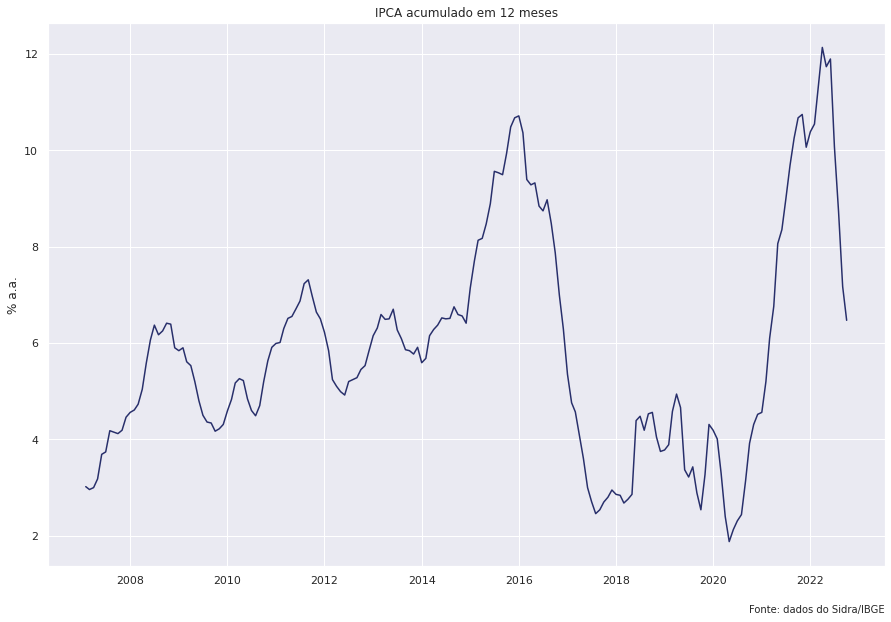

In [6]:
# Filtra somente para o IPCA acumulado em 12 meses
ipca_12m = (ipca.pipe(lambda x: x.loc[x.variable == 'Var. MM12M (%)']))

# Plota o IPCA acumulado em 12 meses
sns.lineplot(x = 'date',
             y = 'value',
             data = ipca_12m).set(title = 'IPCA acumulado em 12 meses',
                                                           xlabel = '',
                                                           ylabel = '% a.a.')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: dados do Sidra/IBGE',
            xy = (1.0, -0.08),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

Text(1.0, -0.13, 'Fonte: dados do Sidra/IBGE')

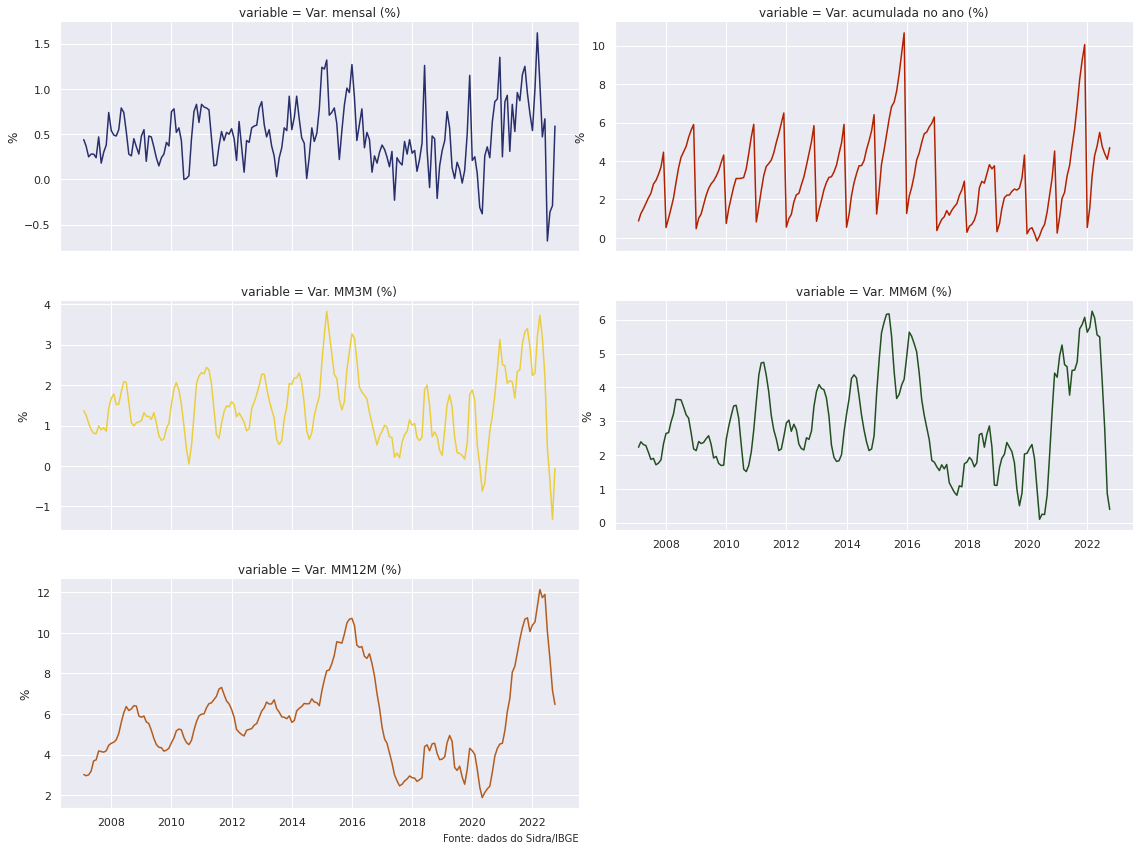

In [7]:
# Plota todas as variações
g = sns.FacetGrid(ipca, col = 'variable',
                  col_wrap = 2,
                  hue = 'variable',
                  sharey = False,
                  height = 4,
                  aspect = 2)


g.map_dataframe(sns.lineplot, 
                x = 'date',
                y = 'value').set(xlabel = "",
                                 ylabel = '%')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: dados do Sidra/IBGE',
            xy = (1.0, -0.13),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

In [8]:
# Importa as variações e os pesos dos grupos do IPCA
ipca_gp_raw = sidrapy.get_table(table_code = '7060',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,66',
                             period = 'all',
                             classification = '315/7170,7445,7486,7558,7625,7660,7712,7766,7786',
                             verify_ssl=False)

In [9]:
# Realiza a limpeza e manipulação da tabela
ipca_gp =  (
    ipca_gp_raw
    .loc[1:,['V', 'D2C', 'D3N', 'D4N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable',
                       'D4N': 'groups'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'variacao',
                                                        'IPCA - Peso mensal': 'peso'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float),
            groups = lambda x: x['groups'].astype(str)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01'])
)

In [10]:
# Torna em formato wide e calcula a contribuição de cada grupo pro IPCA
ipca_gp_wider = (
    ipca_gp
    .pivot_table(index = ['date', 'groups'],
                 columns = 'variable',
                 values = 'value')
    .reset_index()
    .assign(contribuicao = lambda x: (x.peso * x.variacao) / 100)
)

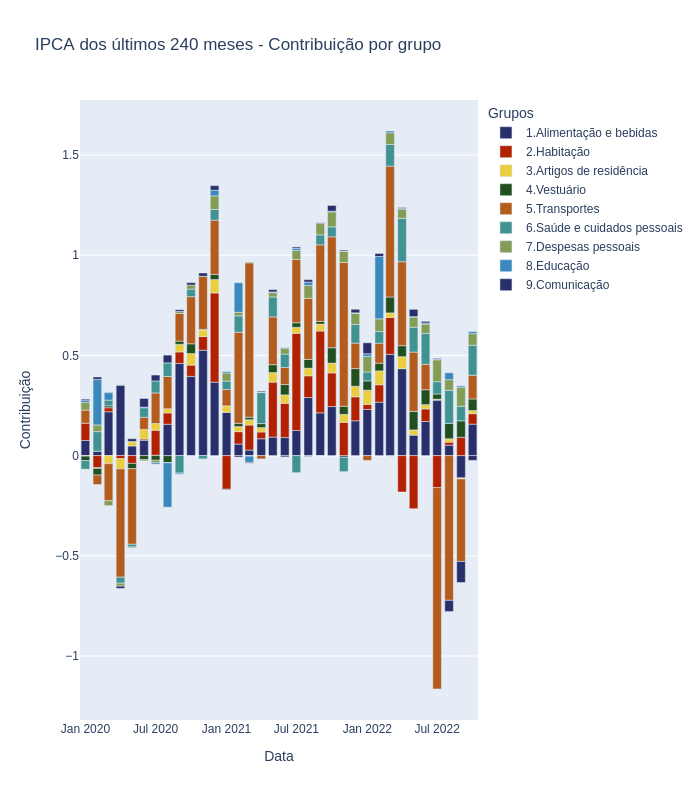

In [11]:
# Plota a contribuição de cada grupo com plotly
fig = px.bar(ipca_gp_wider, title="IPCA dos últimos 240 meses - Contribuição por grupo",
       x = 'date',
       y = 'contribuicao',
       color = 'groups',
       color_discrete_sequence = colors,
       labels={'date':'Data', 'contribuicao':'Contribuição', 'groups':'Grupos'}, 
       height=800, color_continuous_scale='Inferno')
fig.show()
fig.write_image("./temp.png")
Image('./temp.png')